# Lake model continued - sensitivity analysis

In the previous week you used the lake problem as a means of getting acquainted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of the [open exploration tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the separate anthropogenic release decision**

There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis.

## 1. SOBOL
1. Apply Sobol with 3 separate release policies (0, 0.05, and 0.1) and analyse the results for each release policy separately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each separate release policy and apply sobol to each of the three separate release policies. If this sounds too complicated, just do it on each release policy separately.*

In [1]:
from ema_workbench import Samplers
from lakemodel_function import lake_problem
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome
import numpy as np
from ema_workbench import Policy
from ema_workbench import perform_experiments

# Instantiate the model
#Don't use spacebar in model name it reutrns an error
model = Model('LakeProblem', function=lake_problem)

# Specify uncertainties
model.uncertainties = [
    RealParameter('mean', 0.01, 0.05),  # mean of the lognormal distribution
    RealParameter('stdev' , 0.001, 0.005), # standard deviation of the lognormal distribution
    RealParameter ('b', 0.1, 0.45),       # decay paramter in the lake
    RealParameter ('q', 2, 4.5),        # natural recycling rate
    RealParameter ('delta', 0.93, 0.99),     # discount rate for financial benefits
]

# Set levers to 0 so we run simualtion wihtout interventions first, one for each time step
model.levers = [
    RealParameter(f'l{t}', 0.0, 0.0) #runs from l0 to l99
    for t in range(100)
]

# Specify outcomes
#Using ScalarOutcomes to capture a single value per run being put out
model.outcomes = [
    ScalarOutcome('avg_phosphorus'),  # average concentration of phosphor in the lake
    ScalarOutcome('utility'),     # economic benefit derived from polluting the lake
    ScalarOutcome('inertia'),      # year-over-year change in the anthropogenic pollution rate
    ScalarOutcome('reliability')   # fraction of years when the pollution in the lake is below the critical threshold
]

# Create 3 Policies
release_values = [0.0, 0.05, 0.1]
policies = []

for i, r in enumerate(release_values):
    release = np.full(100, r)
    lever_dict = {f'l{t}': release[t] for t in range(100)}
    policies.append(Policy(f'policy_{i}', **lever_dict))

# Run lake model with policies
N = 1000
results = perform_experiments(model, scenarios=N, policies=policies)
experiments, outcomes = results

C:\Users\muham\OneDrive - Delft University of Technology\Documents\Kuliah\S2\Q1.4\Model-based Decision Making\Assignments\venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
100%|█████████████████████████████████████| 3000/3000 [00:03<00:00, 879.73it/s]


In [26]:
outcomes

{'avg_phosphorus': array([0.06079486, 0.13936968, 0.10521569, ..., 3.30465686, 8.24051128,
        4.51971965], shape=(3000,)),
 'utility': array([0.        , 0.        , 0.        , ..., 2.41561564, 0.59303792,
        0.63932585], shape=(3000,)),
 'inertia': array([0., 0., 0., ..., 0., 0., 0.], shape=(3000,)),
 'reliability': array([1.  , 1.  , 1.  , ..., 0.07, 0.03, 0.05], shape=(3000,))}

In [5]:
# Step 1: Run Sobol Sampling Experiments
N = 1000  # Base sample size
sobol_results = perform_experiments(
    model,
    scenarios=N,
    uncertainty_sampling=Samplers.SOBOL, policies=policies)


sobol_experiments, sobol_outcomes = sobol_results

C:\Users\muham\OneDrive - Delft University of Technology\Documents\Kuliah\S2\Q1.4\Model-based Decision Making\Assignments\venv\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
100%|███████████████████████████████████| 36000/36000 [00:41<00:00, 867.78it/s]


In [25]:
sobol_outcomes

{'avg_phosphorus': array([0.12306214, 0.1851415 , 0.12339302, ..., 2.76023014, 2.74934547,
        2.74871789], shape=(36000,)),
 'utility': array([0.        , 0.        , 0.        , ..., 0.96603473, 0.96603473,
        0.96603473], shape=(36000,)),
 'inertia': array([0., 0., 0., ..., 0., 0., 0.], shape=(36000,)),
 'reliability': array([1.    , 1.    , 1.    , ..., 0.2621, 0.1983, 0.1987],
       shape=(36000,))}

In [16]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Problem definition from model
problem = get_SALib_problem(model.uncertainties)
D = len(problem['names'])
expected_len = N * (D + 2)

# Step 1: Perform Sobol for each policy and each outcome
sobol_results = {}

for policy_name in ['policy_0', 'policy_1', 'policy_2']:
    sobol_results[policy_name] = {}
    idx = sobol_experiments['policy'] == policy_name

    for outcome_name in outcomes.keys():
        y = sobol_outcomes[outcome_name][idx]
        y = y[:expected_len]
        Si = sobol.analyze(problem, y, calc_second_order=False)
        sobol_results[policy_name][outcome_name] = Si

C:\Users\muham\OneDrive - Delft University of Technology\Documents\Kuliah\S2\Q1.4\Model-based Decision Making\Assignments\venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\muham\OneDrive - Delft University of Technology\Documents\Kuliah\S2\Q1.4\Model-based Decision Making\Assignments\venv\Lib\site-packages\SALib\analyze\sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()



========== Sobol Results for policy_0 ==========


,S1,S1_conf,ST,ST_conf
b,-0.035929,0.072241,0.586083,0.079849
delta,0.149572,0.074681,0.563460,0.075613
mean,0.277705,0.074573,0.644585,0.088782
q,0.323473,0.095380,0.790921,0.079095
stdev,0.350390,0.100901,0.957852,0.078375


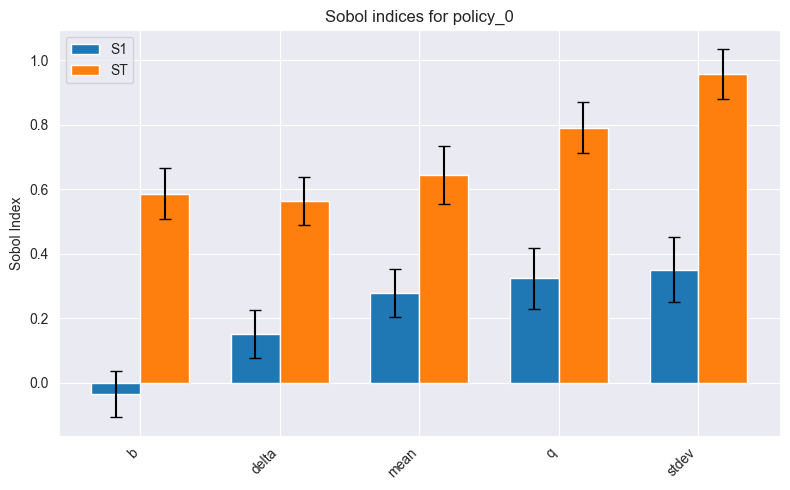


========== Sobol Results for policy_1 ==========


,S1,S1_conf,ST,ST_conf
b,-0.049442,0.059341,0.450585,0.051421
delta,0.136422,0.067445,0.537483,0.053224
mean,0.246180,0.078755,0.601101,0.057819
q,0.324616,0.078113,0.721262,0.068241
stdev,0.367925,0.086092,0.915285,0.067268


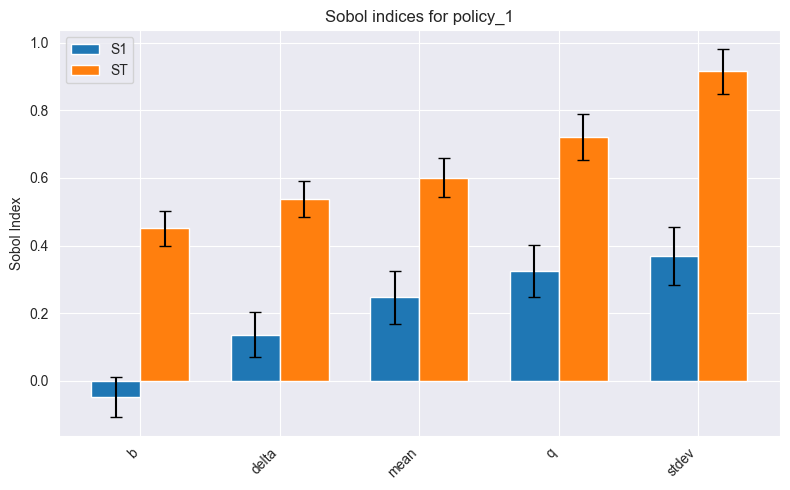


========== Sobol Results for policy_2 ==========


,S1,S1_conf,ST,ST_conf
b,0.012177,0.084667,0.512355,0.093289
delta,0.128820,0.103956,0.576740,0.087529
mean,0.317382,0.117430,0.706420,0.105930
q,0.289472,0.109970,0.699624,0.093888
stdev,0.432892,0.131285,0.910942,0.110288


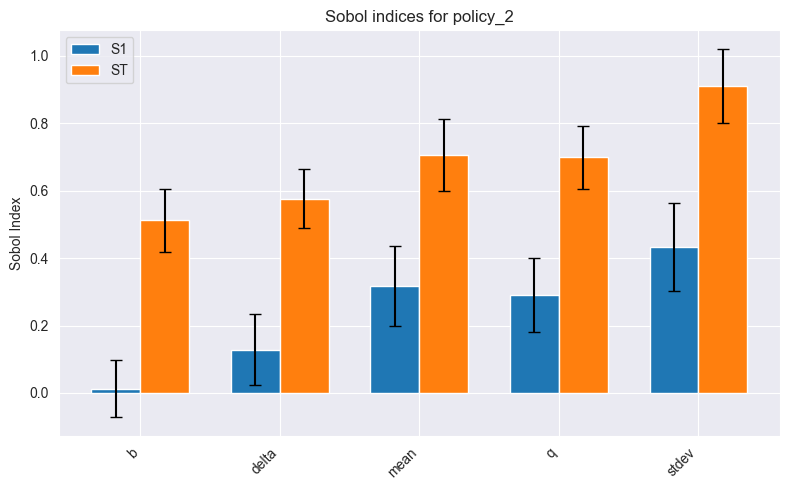

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---- Summary Table Function ----
def summarize_sobol_result(Si, parameter_names):
    return pd.DataFrame({
        'S1': Si['S1'],
        'S1_conf': Si['S1_conf'],
        'ST': Si['ST'],
        'ST_conf': Si['ST_conf']
    }, index=parameter_names)

# ---- Bar Plot Function ----
def plot_sobol_indices(Si, title, parameter_names):
    x = np.arange(len(parameter_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, Si['S1'], width, yerr=Si['S1_conf'], label='S1', capsize=4)
    ax.bar(x + width/2, Si['ST'], width, yerr=Si['ST_conf'], label='ST', capsize=4)

    ax.set_ylabel('Sobol Index')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(parameter_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# --- Loop through and display results ---
def display_sobol_visuals(sobol_analysis_results, parameter_names):
    for policy_name, Si in sobol_analysis_results.items():
        print(f"\n========== Sobol Results for {policy_name} ==========")
        display(summarize_sobol_result(Si, parameter_names))
        plot_sobol_indices(Si, f"Sobol indices for {policy_name}", parameter_names)

display_sobol_visuals(sobol_analysis_results, problem['names'])

## 2. Feature scoring
Repeat the above analysis for the 3 release policies but now with extra trees [feature scoring](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results. See also the [features scoring](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#feature-scoring) section of the tutorial.*


In [34]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.feature_scoring import RuleInductionType
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def compute_feature_scores_all(x, y_dict):
    return feature_scoring.get_feature_scores_all(
        x=x,
        y=y_dict,
        alg='extra trees',
        mode=RuleInductionType.REGRESSION,
        nr_trees=100,
        max_features=0.6,
        random_state=123
    )

# Collect results in nested dictionaries
lhs_scores_by_policy = {}
sobol_scores_by_policy = {}

# Policy names to iterate over
policy_names = ['policy_0', 'policy_1', 'policy_2']

for policy_name in policy_names:
    # ---- LHS
    lhs_idx = experiments['policy'] == policy_name
    lhs_x = experiments[lhs_idx][model.uncertainties.keys()]
    lhs_y_dict = {out: outcomes[out][lhs_idx] for out in outcomes}
    lhs_scores_by_policy[policy_name] = compute_feature_scores_all(lhs_x, lhs_y_dict)

    # ---- Sobol
    sobol_idx = sobol_experiments['policy'] == policy_name
    sobol_x = sobol_experiments[sobol_idx][model.uncertainties.keys()]
    sobol_y_dict = {out: sobol_outcomes[out][sobol_idx] for out in sobol_outcomes}
    sobol_scores_by_policy[policy_name] = compute_feature_scores_all(sobol_x, sobol_y_dict)



Policy: policy_0
▶ LHS sampling


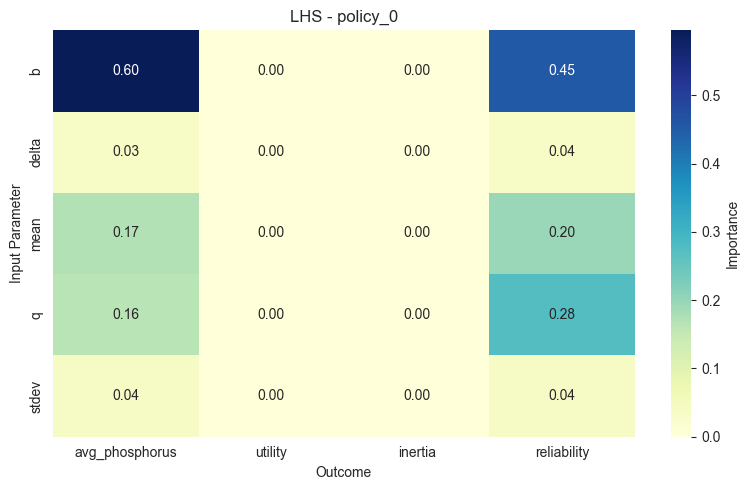

▶ Sobol sampling


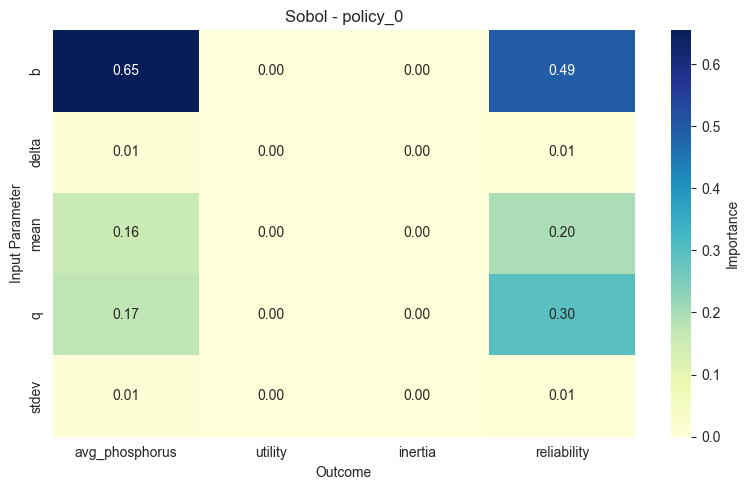


Policy: policy_1
▶ LHS sampling


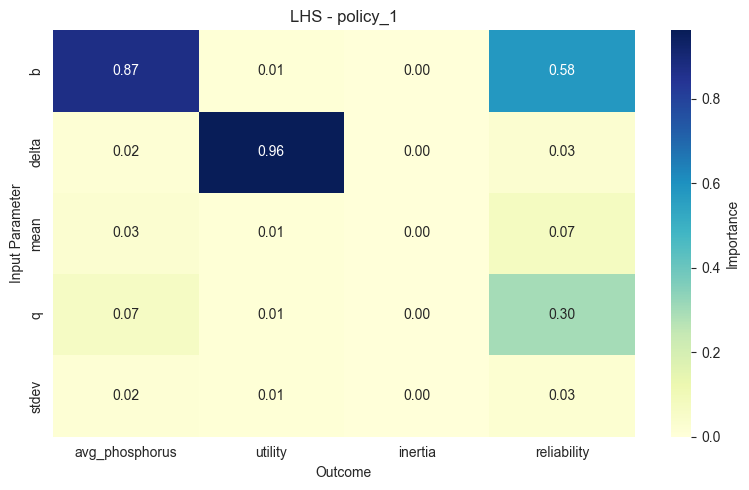

▶ Sobol sampling


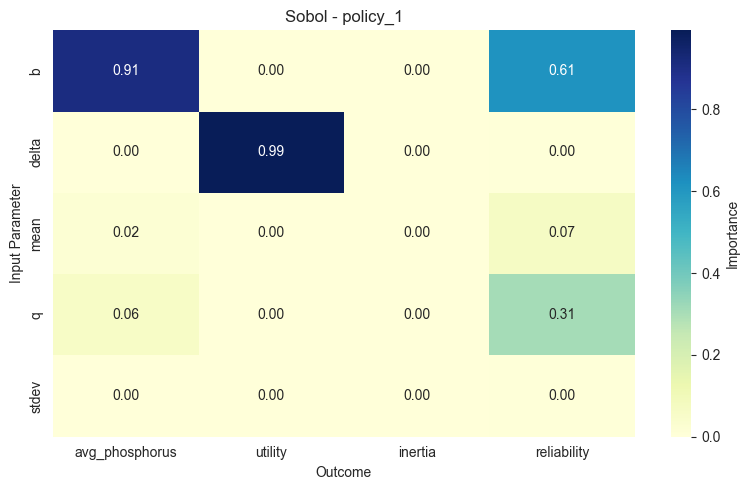


Policy: policy_2
▶ LHS sampling


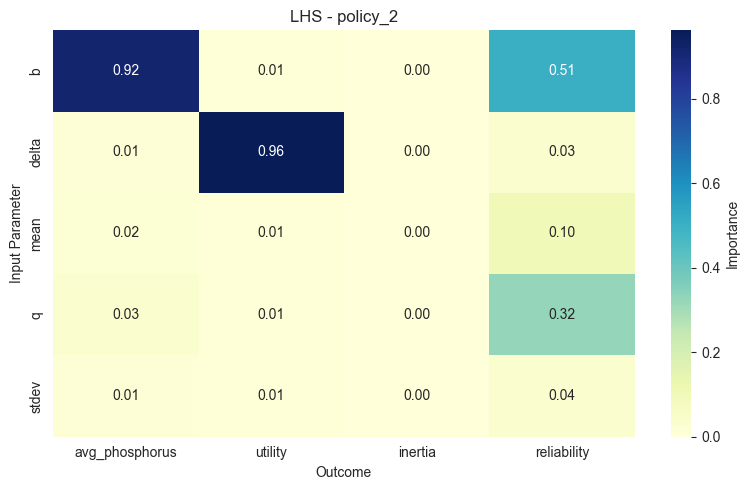

▶ Sobol sampling


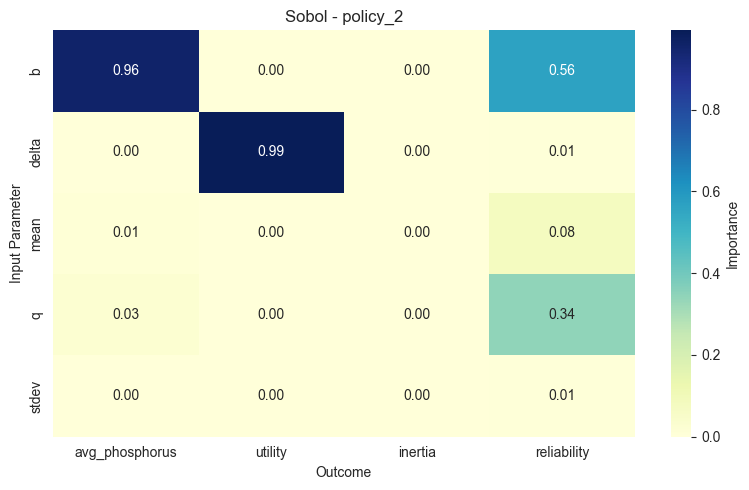

In [35]:
def plot_feature_score_heatmap(score_df, title):
    plt.figure(figsize=(8, 5))
    sns.heatmap(score_df, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Importance'})
    plt.title(title)
    plt.ylabel("Input Parameter")
    plt.xlabel("Outcome")
    plt.tight_layout()
    plt.show()

for policy_name in policy_names:
    print(f"\nPolicy: {policy_name}")

    print("▶ LHS sampling")
    plot_feature_score_heatmap(lhs_scores_by_policy[policy_name], f"LHS - {policy_name}")

    print("▶ Sobol sampling")
    plot_feature_score_heatmap(sobol_scores_by_policy[policy_name], f"Sobol - {policy_name}")
